In [771]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from scipy.optimize import minimize, NonlinearConstraint
from scipy.stats import norm
from assets_allocator import AssetsAllocator
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [772]:

optimalPortfolios = pd.DataFrame(np.array([[0.6, 0.7], [0.4, 0.3]]), columns=['ACWI', 'TBSC'])
optimalPortfolios.head()

goals = pd.DataFrame({'Nazwa': ["Dom", 'Emerytura']})    
        

In [773]:
assetsAllocator = AssetsAllocator(optimalPortfolios)
assetsAllocation = assetsAllocator.expectedAllocation(goals)
print(assetsAllocation)

      Dom  Emerytura
ACWI  0.0        0.0
TBSC  0.0        0.0


In [774]:
#sheet_name='2011-2021'
acwi_tbsc = pd.read_excel('./acwi_tbsc.xlsx')
acwi_tbsc.head()

,ACWI,TBSC
0,0.020931,0.005868
1,-0.004996,0.002708
2,0.012963,0.012686
3,0.008176,0.016935
4,-0.006637,0.004393


In [775]:
means = acwi_tbsc.mean() *12
cov_table = acwi_tbsc.cov() * 12

weights = np.array([0.6, 0.4])
print(means)
print(cov_table)
print(acwi_tbsc.std()*np.sqrt(12))

ACWI    0.134085
TBSC    0.027678
dtype: float64
          ACWI      TBSC
ACWI  0.012553  0.000395
TBSC  0.000395  0.001240
ACWI    0.112039
TBSC    0.035215
dtype: float64


In [776]:
def pstd(weights, cov_matrix):
    #variance = np.transpose(weights)@cov_matrix@weights
    variance = np.dot(weights.T, np.dot(cov_matrix, weights))
    return np.sqrt(variance)

def pmean(weights, means):
    return np.sum(weights * means)

In [777]:
std = pstd(weights=weights, cov_matrix=cov_table)
print(std)



0.07005106014425842


In [778]:
def probabilityOfRequiredReturns(weights, expectedReturn, portfolioMeanReturns, portfolioCovariance: pd.DataFrame):
    portfolioMean = pmean(weights=weights,means=portfolioMeanReturns)
    portfolioStd = pstd(weights=weights, cov_matrix=portfolioCovariance)          
    return norm.cdf(x=expectedReturn, loc=portfolioMean, scale=portfolioStd)

In [779]:
probabilityOfRequiredReturns(weights=weights,expectedReturn=0.07,portfolioMeanReturns=means,portfolioCovariance=cov_table)

0.3793328479433782

In [780]:
allocations = []

xs = (0.1 * n for n in range(11))

for n in xs:
    allocations.append(np.array([n, 1-n]))

print(allocations)

[array([0., 1.]), array([0.1, 0.9]), array([0.2, 0.8]), array([0.3, 0.7]), array([0.4, 0.6]), array([0.5, 0.5]), array([0.6, 0.4]), array([0.7, 0.3]), array([0.8, 0.2]), array([0.9, 0.1]), array([1., 0.])]


In [781]:
expectedReturn = 0.02
for n in allocations:
    p = probabilityOfRequiredReturns(n,expectedReturn=expectedReturn, portfolioMeanReturns=means, portfolioCovariance=cov_table)
    p = np.round(p,4)*-1
    print(f'Porfolio: {n}, propability: {p}')

Porfolio: [0. 1.], propability: -0.4137
Porfolio: [0.1 0.9], propability: -0.2986
Porfolio: [0.2 0.8], propability: -0.2213
Porfolio: [0.3 0.7], propability: -0.182
Porfolio: [0.4 0.6], propability: -0.1643
Porfolio: [0.5 0.5], propability: -0.1567
Porfolio: [0.6 0.4], propability: -0.1536
Porfolio: [0.7 0.3], propability: -0.1527
Porfolio: [0.8 0.2], propability: -0.1529
Porfolio: [0.9 0.1], propability: -0.1535
Porfolio: [1. 0.], propability: -0.1543


In [782]:
start_pos = [0.5,0.5]

#Says one minus the sum of all variables must be zero
constraint = NonlinearConstraint(lambda x: x.sum(), 1,1)

#Required to have non negative values
bnds = [(0,1), (0,1)]

result = minimize(probabilityOfRequiredReturns,start_pos, args=(0.07,means,cov_table), bounds=bnds, constraints=constraint)

print(result)

     fun: 0.28366705888896804
     jac: array([-0.21163855, -0.07758224])
 message: 'Optimization terminated successfully'
    nfev: 12
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([1.00000000e+00, 2.22044605e-16])


In [783]:
def findAssetsAllocation(requiredRateOfReturn, portfolioReturns, portfolioCov):
    result = result = minimize(
        probabilityOfRequiredReturns,
        [0.5,0.5], 
        args=(requiredRateOfReturn,portfolioReturns,portfolioCov), 
        bounds=[(0,1),(0,1)], 
        constraints=NonlinearConstraint(lambda x: x.sum(), 1,1)
        )
    return (np.round(result.fun,2), [np.round(n,1) for n in result.x])
    

In [784]:
probability, portfolio = findAssetsAllocation(0.07, means, cov_table)
row = [probability, *portfolio]
print(f'Portfolio: {portfolio}, probability: {probability}')
print(row)


Portfolio: [1.0, 0.0], probability: 0.28
[0.28, 1.0, 0.0]


In [785]:
portfolio_waights = pd.DataFrame({'RequiredReturn':[], 'Propability': [], 'Acwi': [], 'TBSC': []})

requiredReturns = [n * 0.005 for n in range(1, 41)]

for n in requiredReturns:
    probability, portfolio = findAssetsAllocation(n,means,cov_table)
    print(f'RequiredRate: {n}, Portfolio: {portfolio}, probability: {probability}')
    


RequiredRate: 0.005, Portfolio: [0.4, 0.6], probability: 0.1
RequiredRate: 0.01, Portfolio: [0.5, 0.5], probability: 0.12
RequiredRate: 0.015, Portfolio: [0.6, 0.4], probability: 0.14
RequiredRate: 0.02, Portfolio: [0.7, 0.3], probability: 0.15
RequiredRate: 0.025, Portfolio: [1.0, 0.0], probability: 0.17
RequiredRate: 0.03, Portfolio: [1.0, 0.0], probability: 0.18
RequiredRate: 0.035, Portfolio: [1.0, 0.0], probability: 0.19
RequiredRate: 0.04, Portfolio: [1.0, 0.0], probability: 0.2
RequiredRate: 0.045, Portfolio: [1.0, 0.0], probability: 0.21
RequiredRate: 0.05, Portfolio: [1.0, 0.0], probability: 0.23
RequiredRate: 0.055, Portfolio: [1.0, 0.0], probability: 0.24
RequiredRate: 0.06, Portfolio: [1.0, 0.0], probability: 0.25
RequiredRate: 0.065, Portfolio: [1.0, 0.0], probability: 0.27
RequiredRate: 0.07, Portfolio: [1.0, 0.0], probability: 0.28
RequiredRate: 0.075, Portfolio: [1.0, 0.0], probability: 0.3
RequiredRate: 0.08, Portfolio: [1.0, 0.0], probability: 0.31
RequiredRate: 0.085

In [786]:
allocations = []

xs = (0.1 * n for n in range(11))

for n in xs:
    allocations.append(np.array([n, 1-n])) 


portfolioResults = np.zeros((4,len(allocations)), np.float64)

for n in range(len(allocations)):
    mean = pmean(allocations[n],means)
    std = pstd(allocations[n], cov_table)
    allocation =  allocations[n]
    print(f'allocations: {allocation}, mean: {mean}, std: {std}')



allocations: [0. 1.], mean: 0.027678296419985458, std: 0.035215452091304555
allocations: [0.1 0.9], mean: 0.03831891835378337, std: 0.034657970508677007
allocations: [0.2 0.8], mean: 0.04895954028758129, std: 0.03771301140818877
allocations: [0.3 0.7], mean: 0.059600162221379205, std: 0.0436281674503585
allocations: [0.4 0.6], mean: 0.07024078415517712, std: 0.05142579330051563
allocations: [0.5 0.5], mean: 0.08088140608897502, std: 0.06038093154305164
allocations: [0.6 0.4], mean: 0.09152202802277294, std: 0.07005106014425844
allocations: [0.7 0.3], mean: 0.10216264995657086, std: 0.08017789356531406
allocations: [0.8 0.2], mean: 0.11280327189036878, std: 0.09060843041194146
allocations: [0.9 0.1], mean: 0.12344389382416669, std: 0.10124885264914829
allocations: [1. 0.], mean: 0.1340845157579646, std: 0.11203937754080365


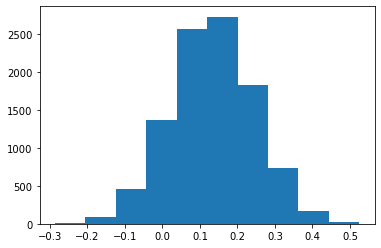

In [787]:
#weight 100,00

values = np.random.normal(0.134,0.112,10000)

plt.hist(values)
plt.show()

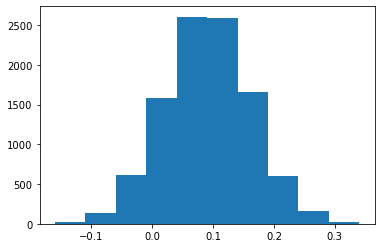

In [788]:
#weight: 60%,40%

values = np.random.normal(0.091,0.07,10000)

plt.hist(values)
plt.show()

In [789]:
def generateReturns(period, mean, std):
    returns = np.zeros(period)
    for n in range(period):
        returns[n]= np.random.normal(mean, std)
    return returns

def generatePortfolio(returns, initial,payment):
    portfolioValue = initial
    
    for r in returns:
        portfolioValue = (portfolioValue + payment)* (1+r)

    return np.round(portfolioValue,2)

def probabilityOfGoal(goal, values: np.array):
    return np.count_nonzero(values >= goal)/len(values)
    #return [np.percentile(values,25), np.percentile(values,50), np.percentile(values,50)]


def goalProbability(goal, period, initial, payment, mean, std):
    ntrials = 10000
    portfolioValues = np.zeros(ntrials)
    
    for n in range(ntrials):
      returns = generateReturns(period, mean,std)
      portfolioValues[n] = generatePortfolio(returns, initial,payment)
    
    return probabilityOfGoal(goal,portfolioValues)

In [790]:
goal = 12250
initial = 10000
payment = 0
period = 3
weights = np.array([1,0])
mean = pmean(weights,means)
std = pstd(weights, cov_matrix=cov_table)
#mean = 0.093
#std = 0.1445
probability = goalProbability(goal, period, initial, payment, mean, std)
print(probability)

0.819


In [791]:
array = np.array([[1,2,3], [4,5,6]])
array.T


array([[1, 4],
       [2, 5],
       [3, 6]])

In [792]:
mean = 0.093
std = 0.1445
expectedReturn=0.07
1- norm.cdf(x=expectedReturn, loc=mean, scale=std)


0.5632323532849406

In [793]:
mean = 0.9417
std = 0.4675
expectedReturn=0.9672
1- norm.cdf(x=expectedReturn, loc=mean, scale=std)

0.478250297488931

In [794]:
mean = 0.093
std = 0.1445
weights = np.array([1,0])
#mean = pmean(weights,means)
#std = pstd(weights, cov_table)
expectedReturn=0.07
returns = np.zeros(10000)
t = 10

def randCumulative():
    cumulative = 1
    for n in range(t):
        cumulative = cumulative * (1+ np.random.normal(mean,std))
    return cumulative ** (1/t) - 1

for n in range (10000):
    returns[n] = randCumulative()

probabilityOfGoal(expectedReturn,returns)


0.6222

In [795]:
print(generateReturns(period, mean, std))
print(std)

[ 0.03722284  0.02101704 -0.04997536]
0.1445


In [796]:
t =10
r = np.log(500000/400000)*(1/t)
std = 0.1
ppf = norm.ppf(0.8)
mean = 0.5*std**2+ (ppf/(t**(1/2)))*std+r
print(mean)



0.053928755383930785


In [797]:
t =10
#r = np.log(500000/400000)*(1/t)
r = 0.07
std = 0.1445
ppf = norm.ppf(0.6149)
mean = 0.5*std**2+ (ppf/(t**(1/2)))*std+r
print(mean)


0.09378821647533797


In [798]:
np.log(100)
#np.e**7.01775867
#np.e**4.605170185988092

4.605170185988092

In [799]:
meanMin = 0.0526
stdMin = 0.0374
meanMax = 0.0886
stdMax = 0.1954
#Wmax = 1834
W0 = 100
T = 12
iMax = 476
def Wmax(t,meanMax,stdMin,stdMax):
    return W0*np.e**((meanMax-(stdMin**2/2))*t + 3*stdMax*np.sqrt(t))
def Wmin(t, meanMin, stdMin, stdMax):
    return W0*np.e**((meanMin-stdMax**2/2)*t - 3*stdMax*np.sqrt(t))
def Wi(i, imax, Wmin, Wmax):
    return np.log(Wmin)+((i-1)/(imax-1))*(np.log(Wmax) - np.log(Wmin))

for t in range(1,T):
    max = Wmax(t, meanMax, stdMin,stdMax)
    min = Wmin(t, meanMin, stdMin, stdMax)
    W = np.zeros(iMax)
    for i in range (0, iMax):
        W[i] = Wi(i,iMax,min,max)
    print(f"t: {t}, min: {min}, max: {max}, W: {W}")



t: 1, min: 57.53995672215052, max: 196.22673580916378, W: [4.04989689 4.05247961 4.05506232 4.05764504 4.06022776 4.06281048
 4.0653932  4.06797592 4.07055863 4.07314135 4.07572407 4.07830679
 4.08088951 4.08347223 4.08605494 4.08863766 4.09122038 4.0938031
 4.09638582 4.09896854 4.10155125 4.10413397 4.10671669 4.10929941
 4.11188213 4.11446485 4.11704756 4.11963028 4.122213   4.12479572
 4.12737844 4.12996116 4.13254387 4.13512659 4.13770931 4.14029203
 4.14287475 4.14545747 4.14804018 4.1506229  4.15320562 4.15578834
 4.15837106 4.16095378 4.16353649 4.16611921 4.16870193 4.17128465
 4.17386737 4.17645009 4.1790328  4.18161552 4.18419824 4.18678096
 4.18936368 4.1919464  4.19452911 4.19711183 4.19969455 4.20227727
 4.20485999 4.2074427  4.21002542 4.21260814 4.21519086 4.21777358
 4.2203563  4.22293901 4.22552173 4.22810445 4.23068717 4.23326989
 4.23585261 4.23843532 4.24101804 4.24360076 4.24618348 4.2487662
 4.25134892 4.25393163 4.25651435 4.25909707 4.26167979 4.26426251
 4.266

In [800]:
max = Wmax(t, meanMax, stdMin,stdMax)
min = Wmin(t, meanMin, stdMin, stdMax)
logW0 = 4.605170185988092
W = np.zeros(iMax)
for i in range (0, iMax):
    W[i] = Wi(i,iMax,min,max)
We = W-logW0
E = We[We>=0].min()
print(E)
W = W-E



0.0018323897958030244


In [801]:
''' logMax = 7.50683674
Wmax = np.e**logMax
Wmax = Wmax*np.e**-E
Wmax '''

' logMax = 7.50683674\nWmax = np.e**logMax\nWmax = Wmax*np.e**-E\nWmax '

In [802]:
Wmax = Wi(476,476,Wmin(11, meanMin, stdMin, stdMax),Wmax(11, meanMax, stdMin, stdMax))
Wmax = Wmax - 0.0018323897958030244
np.e**Wmax

1834.3584270143306

In [803]:
from goal_optimasier import generateGrid
meanMin = 0.0526
stdMin = 0.0374
meanMax = 0.0886
stdMax = 0.1954
W0 = 100
T = 1
iMax = 10

grid = generateGrid(W0,T,iMax, meanMin, stdMin, meanMax, stdMax)

print(grid)

#TODO
# dodawać 1 do iMax w metodzie, grid to iMax + 1
# zrobić assertację, do całej tablicy
#dodać grid z chashflowami

[[ 50.58320071  57.97023288  66.43604702  76.13818548  87.25719769
  100.         114.60372628 131.34014078 150.52069544 172.50232581]]


In [804]:
def prob1(W0, W1, mean, std, h):
    return (1/(std*np.sqrt(h)))*(np.log(W1/W0)-((mean-(std**2)/2)*h))
def prob2(W0, W1, mean, std, h):
    return norm.pdf((np.log(W1/W0)-(mean-0.5*std**2)*h)/(std*np.sqrt(h)))
mean = 0.10
std = 0.01
h = 1
W0 = 100
WI1 = 110
q = prob2(W0, WI1, mean, std, h)
#norm.pdf(q)
q

0.35823066284185373

In [825]:
from goal_optimasier import calculateTransitionPropabilities

W0 = 100
meanMin = 0.0526
stdMin = 0.0374
meanMax = 0.0886
stdMax = 0.1954
W1 = generateGrid(W0,1,20,meanMin,stdMin,meanMax,stdMax)[0]

portfolios = [[meanMin,stdMin],[meanMax, stdMax]]

for porfolio in portfolios:
    print(np.round(calculateTransitionPropabilities(W0, W1, porfolio[0], porfolio[1], 1),2))



[0.   0.   0.   0.   0.   0.   0.   0.   0.01 0.26 0.65 0.08 0.   0.
 0.   0.   0.   0.   0.   0.  ]
[0.   0.   0.   0.01 0.02 0.03 0.05 0.08 0.1  0.12 0.13 0.13 0.11 0.08
 0.06 0.04 0.02 0.01 0.   0.  ]


In [850]:
from goal_optimasier import calculateTransitionPropabilities

W0 = 100
meanMin = 0.0526
stdMin = 0.0374
meanMax = 0.0886
stdMax = 0.1954
iMax = 200
W1 = generateGrid(W0,1,iMax,meanMin,stdMin,meanMax,stdMax)[0]

portfolios = [[meanMin,stdMin],[meanMax, stdMax]]

probabilities = np.zeros((2,iMax))

for i, portfolio in enumerate(portfolios):
    probabilities[i] = calculateTransitionPropabilities(W0,W1, porfolio[0], portfolio[1],1)

values = np.multiply(W1, probabilities)
print(np.round(W1,1))
print(np.round(probabilities,2))
print(np.round(values,1))
print(values.sum(1))
max = values.sum(1).min()
port = np.where(values.sum(1) == max)
port.index
    

[ 57.4  57.8  58.1  58.5  58.9  59.2  59.6  59.9  60.3  60.7  61.1  61.4
  61.8  62.2  62.6  63.   63.4  63.8  64.2  64.6  65.   65.4  65.8  66.2
  66.6  67.   67.4  67.8  68.2  68.7  69.1  69.5  69.9  70.4  70.8  71.2
  71.7  72.1  72.6  73.   73.5  73.9  74.4  74.8  75.3  75.8  76.2  76.7
  77.2  77.7  78.1  78.6  79.1  79.6  80.1  80.6  81.1  81.6  82.1  82.6
  83.1  83.6  84.1  84.7  85.2  85.7  86.2  86.8  87.3  87.9  88.4  88.9
  89.5  90.1  90.6  91.2  91.7  92.3  92.9  93.4  94.   94.6  95.2  95.8
  96.4  97.   97.6  98.2  98.8  99.4 100.  100.6 101.2 101.9 102.5 103.1
 103.8 104.4 105.1 105.7 106.4 107.  107.7 108.3 109.  109.7 110.4 111.
 111.7 112.4 113.1 113.8 114.5 115.2 115.9 116.7 117.4 118.1 118.8 119.6
 120.3 121.1 121.8 122.6 123.3 124.1 124.8 125.6 126.4 127.2 128.  128.8
 129.6 130.4 131.2 132.  132.8 133.6 134.4 135.3 136.1 136.9 137.8 138.6
 139.5 140.4 141.2 142.1 143.  143.9 144.8 145.7 146.6 147.5 148.4 149.3
 150.2 151.1 152.1 153.  154.  154.9 155.9 156.8 157

<function tuple.index(value, start=0, stop=9223372036854775807, /)>